# TSMEAN: Time Series Averaging Demo

Welcome to the **TSMEAN** demonstration notebook! This project provides high-performance algorithms for calculating the **Fréchet Mean** of time series under Dynamic Time Warping (DTW).

In this notebook, we will cover:
1. **DTW Distance**: Calculating distances and alignments between two sequences.
2. **Why Averaging with DTW?**: An example where usual averaging fails.
2. **DBA (DTW Barycenter Averaging)**: The classic full-batch averaging algorithm.
3. **SSG (Stochastic Subgradient Method)**: Modern, scalable averaging.
4. **SSG custom configurations**: Custom step size schedules and optimizers.
4. **Visualization**: Plotting mean estimates and alignment patterns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmean.mean_algorithm import  dtw, dba, ssg, default_init, SubgradientMeanAlgorithm
from tsmean.optimizer import Adam, SGD
from tsmean.visualization import alignment_plot, mean_alignment_plot, LegendStyle
from tsmean.schedule import linear_schedule, sawtooth_schedule
from tsmean.convergence import FunctionSlopeConvergenceChecker

# Set seeds for reproducibility
np.random.seed(42)

# Helper to generate noisy pulses
def generate_pulse(length=100, shift=0, width=1, noise=0.05):
    t = np.linspace(0, 1, length)
    x = np.exp(-100./width * (t - 0.5 - shift/length)**2)
    return x + np.random.normal(0, noise, length)

def generate_pulse_dataset(n_series=10, length=100):
    return [generate_pulse(length=length, width=np.random.uniform(0.5, 2.0),
    shift=np.random.randint(-15, 15)) for _ in range(n_series)]

def generate_wave(length=100, shifts=[-20, 10], widths=[.2, 1], noise=0.05):
    t = np.linspace(0, 1, length)
    x = np.zeros(length)
    for width,shift in zip(widths,shifts):
        x += np.sign(width) * np.exp(-100./abs(width) * (t - 0.5 - shift/length)**2)
        x += np.random.normal(0, noise, length)
    x = np.convolve(x,v=[1,1,1])
    return x

print("Setup complete!")

Setup complete!


# 1. Dynamic Time Warping (DTW)

DTW finds the optimal non-linear alignment between two time series. TSMEAN uses **Numba** to make this calculation extremely fast.

A time series is a sequence of real numbers (or d-dimensional vectors), represented as np.ndarray. First dimension is time, second dimension is feature.

**User friendly data handling:** A univariate `(d=1)` time series of length `n` can be represented as array of shape `(n,)` or `(n,1)`.

```python
import numpy as np

# time series of length 100
x = np.random.randn(100)
x = np.random.randn(100,1)
x = np.random.randn(100,3)
```
can all be used. In contrast, lists such as
```python
x = [1,2,5,4]
```
are intentionally not supported for performance reasons.

A time series dataset `X` is any collection such that `X[i]` is time series in the format described above.

## Example of DTW

DTW Distance: 1.3227
Euclidean Distance: 248.7071


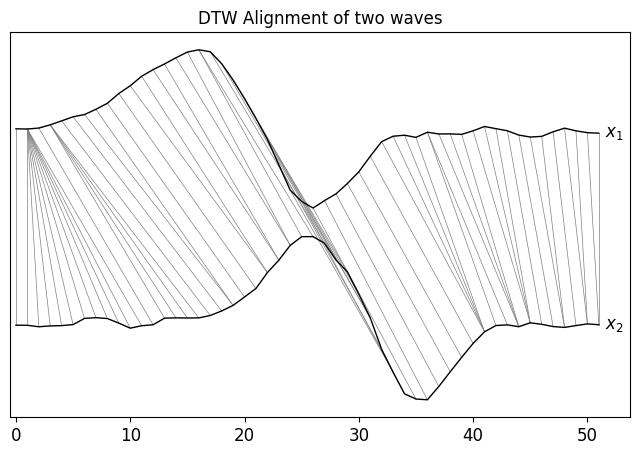

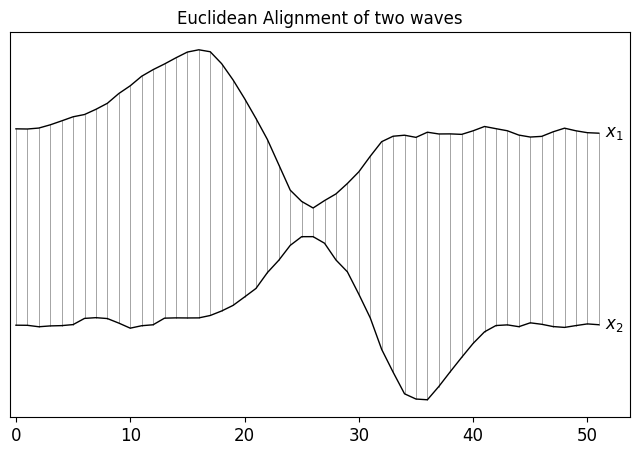

In [2]:
# generate two similar time series with temporal variations
x1 = generate_wave(length=50, shifts=[-10, 0], widths=[2, -1], noise=0.05)
x2 = generate_wave(length=50, shifts=[0, 10], widths=[1, -.5], noise=0.05)

# compute squared DTW distance and squared Euclidean distance
dist, path = dtw(x1, x2)
dist_eucl = np.sum((x1 - x2)**2)
print(f"DTW Distance: {dist:.4f}")
print(f"Euclidean Distance: {dist_eucl:.4f}")


# compare DTW and Euclidean alignment
alignment_plot(x1, x2, path, title="DTW Alignment of two waves", figsize=(8,5))
path_euclid = [(i,i) for i in range(len(x1))]
alignment_plot(x1, x2, path_euclid, title="Euclidean Alignment of two waves", figsize=(8,5))


# 2. Why we need DTW for averaging time series

Time series are not always aligned. That is, the same event might occur at different times in different time series. When using standard means, such as the Euclidean arithmetic mean, this can lead to loss of information.

The following example shows the effect of this issue.

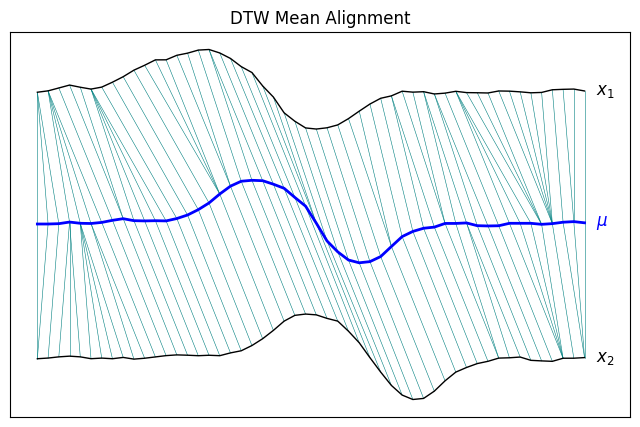

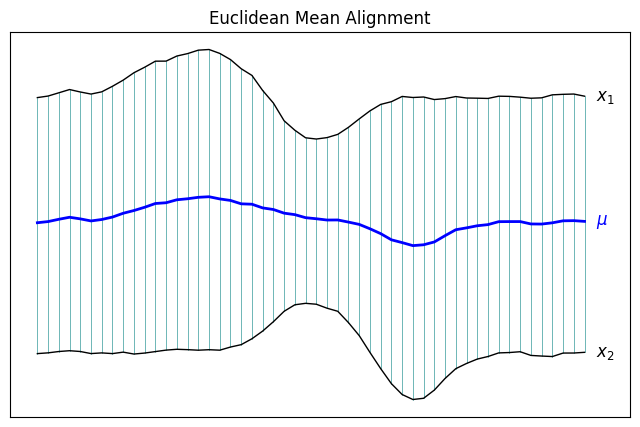

In [3]:
# We use the same time series as in the previous example
x1 = generate_wave(length=50, shifts=[-10, 0], widths=[2, -1], noise=0.05)
x2 = generate_wave(length=50, shifts=[0, 10], widths=[1, -.5], noise=0.05)

# Define the dataset containing the time series x1 and x2
X = [x1,x2]

# Approximate a Fréchet mean under DTW using DBA algorithm
result = dba(X, x0=np.roll(x2,-5))

# Plot the alignments of the time series to the DTW mean
mean_alignment_plot(X,result.mean, p_line_width=0.4, p_colors='teal', x_colors='black' ,
    legend_style=LegendStyle.RIGHT_AT_TIME_SERIES, title="DTW Mean Alignment", 
    font_size=12, figsize=(8,5)) 

# Euclidean mean
x_bar = (x1+x2)/2
p_bar = [(i,i) for i in range(len(x_bar))]
mean_alignment_plot([x1,x2],x_bar,paths=[p_bar,p_bar], p_line_width=0.4, p_colors='teal', 
x_colors='black' , offset=True, latex=True,title='Euclidean Mean Alignment',font_size=12,
legend_style=LegendStyle.RIGHT_AT_TIME_SERIES, figsize=(8,5))



# 3. DTW Barycenter Averaging (DBA)

DBA is an iterative algorithm that minimizes the sum of squared DTW distances. It is a full-batch approach, meaning it processes all time series in every update step. A major advantage is that it is completely hyperparameter-free. A disadvantage is that it can be slow for larger sample sizes.

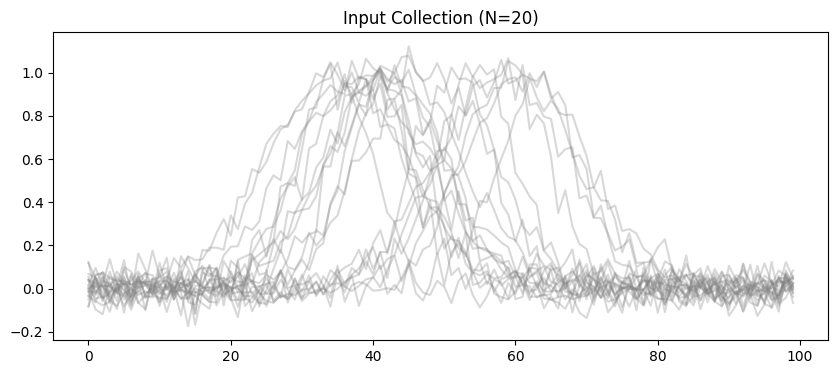

DBA terminated at epoch 7
- Message: Converged because function value remained stable (rel_tol=0.01) for 3 updates
- Success: True
- Fréchet variation: 0.13118771234313742
- Examples processed: 140


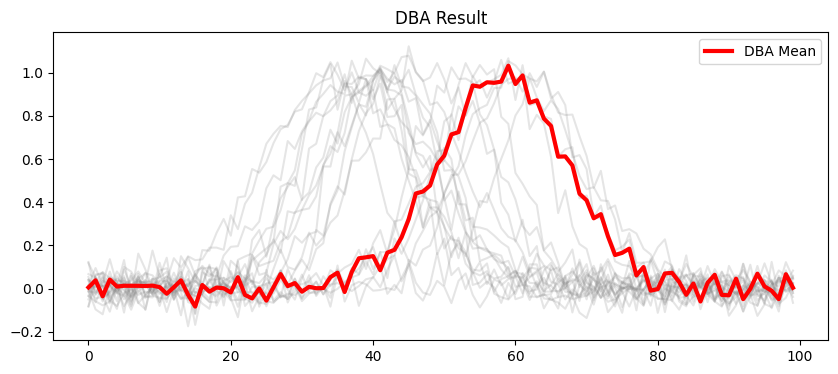

In [4]:
# Generate a collection of noisy, shifted pulses
n_series=20
X = generate_pulse_dataset(n_series=n_series)

plt.figure(figsize=(10, 4))
for x in X:
    plt.plot(x, color='gray', alpha=0.3)
plt.title(f"Input Collection (N={n_series})")
plt.show()

# Compute mean using DBA, compute Fréchet variation and store it in result_dba.F_history
result_dba = dba(X, n_epochs=20)

result_dba.print_stats()

plt.figure(figsize=(10, 4))
for x in X:
    plt.plot(x, color='gray', alpha=0.2)
plt.plot(result_dba.mean, color='red', linewidth=3, label='DBA Mean')
plt.legend()
plt.title("DBA Result")
plt.show()


# 4. Stochastic Subgradient Method (SSG)

For large datasets, full-batch DBA can be slow. SSG processes **minibatches** and supports modern optimizers like **Adam** to converge faster and potentially find better local minima.

The following example compares standard SSG with DBA.

SSG terminated at epoch 9
- Message: Optimization terminated after reaching the maximum number of epochs.
- Success: False
- Fréchet variation: 0.09190851804409407
- Examples processed: 3000
DBA terminated at epoch 9
- Message: Converged because function value remained stable (rel_tol=0.01) for 3 updates
- Success: True
- Fréchet variation: 0.09785076652106414
- Examples processed: 2700


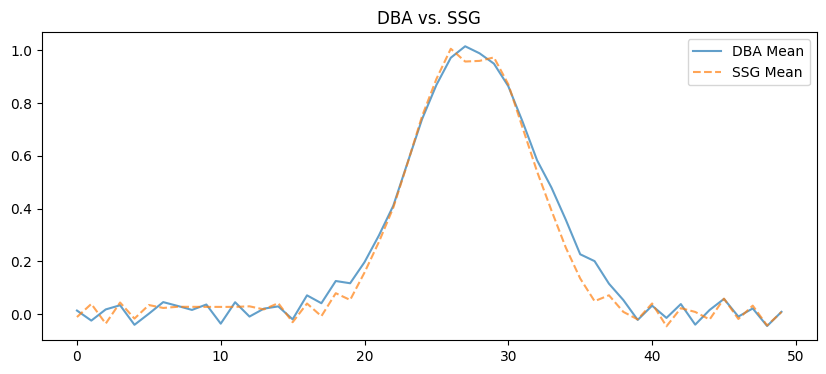

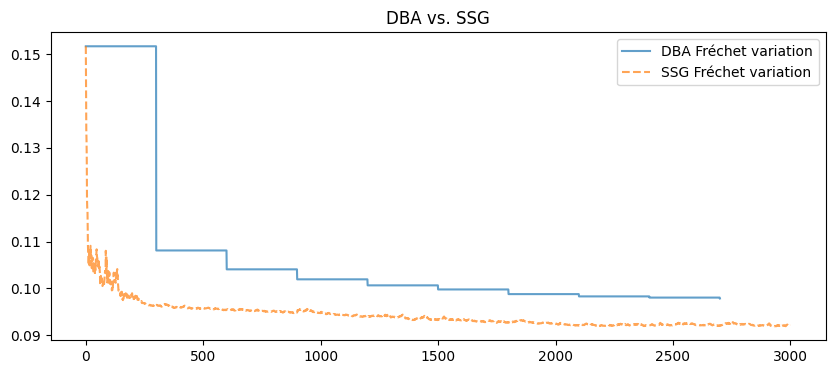

In [5]:

# SSG with vanilla update rule (tsmean.optimizer.SGD)

X = generate_pulse_dataset(n_series=300, length=50)

# use the same initialization for comparision
x0 = default_init(X)

# Below, Feval_interval=1 means that the Fréchet variation is computed for every 
# processed example. This is expensive for SSG. Should only be used be used
# if you really need the history of the Fréchet variation.
result_ssg = ssg(X, x0=x0,
                 batch_size=1, 
                 n_epochs=10, 
                 eta0=0.1, 
                 eta=0.01, 
                 return_best_solution=True,
                 computeF=True,     # Evaluate full Frechet variation periodically
                 Feval_interval=1)  


result_ssg.print_stats()

# run DBA with the same Feval_interval parameter as SSG to enable
# 1:1 comparision of convergence speed
result_dba = dba(X, x0=x0,
                 n_epochs=10, 
                 computeF=True,     
                 Feval_interval=1)  # use same Feval_interval as SSG


result_dba.print_stats()

# Compare results
plt.figure(figsize=(10, 4))
plt.plot(result_dba.mean, label='DBA Mean', alpha=0.7)
plt.plot(result_ssg.mean, label='SSG Mean', alpha=0.7, linestyle='--')
plt.legend()
plt.title("DBA vs. SSG")
plt.show()

# compare Frechet variation
plt.figure(figsize=(10, 4))
plt.plot(result_dba.F_history, label='DBA Fréchet variation', alpha=0.7)
plt.plot(result_ssg.F_history, label='SSG Fréchet variation', alpha=0.7, linestyle='--')
plt.legend()
plt.title("DBA vs. SSG")
plt.show()

# 5. Advanced: Custom Schedules and Optimizers

TSMEAN allows fine-grained control over the optimization process. You can use learning rate schedules (Linear, Sine, Sawtooth) and sifferent SSG optimizers (Adam, AdaDelta, RMSProp) and use second-order information (HSGD).

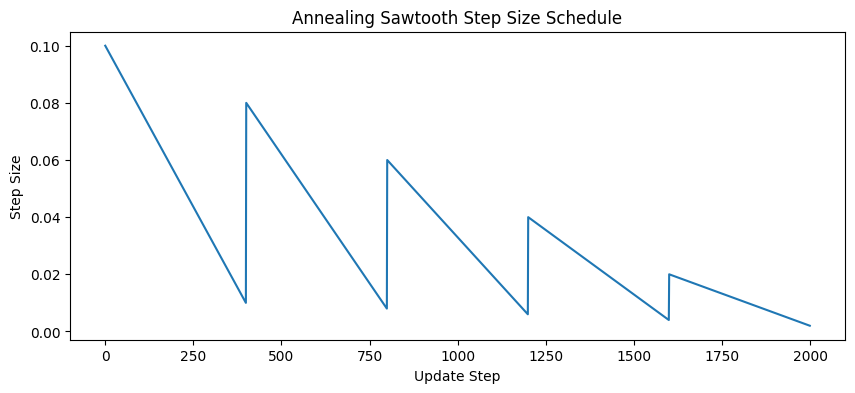

In [6]:
import tsmean
from tsmean.schedule import sawtooth_schedule
from importlib import reload

reload(tsmean.schedule)

# Generate a sawtooth schedule
eta_saw = sawtooth_schedule(size=2000, cycles=5, eta_init=0.1, exponent=1)
plt.figure(figsize=(10,4))
plt.plot(eta_saw)
plt.title("Annealing Sawtooth Step Size Schedule")
plt.ylabel("Step Size")
plt.xlabel("Update Step")
plt.show()

SSG-saw terminated at epoch 9
- Message: Optimization terminated after reaching the maximum number of epochs.
- Success: False
- Fréchet variation: 0.0919949937543405
- Examples processed: 3000


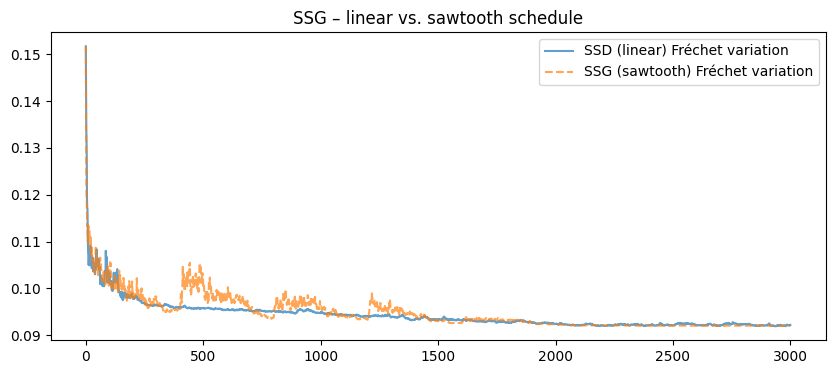

In [7]:
# SSG with sawtooth schedule
result_ssg_saw = ssg(X, x0=x0,
                 batch_size=1, 
                 n_epochs=10, 
                 eta0=0.1, # will be ignored
                 eta=eta_saw, 
                 return_best_solution=True,
                 computeF=True,     # Evaluate full Frechet variation periodically
                 Feval_interval=1,
                 algo_name="SSG-saw")  

#print('SSG-saw stats:')
result_ssg_saw.print_stats()

# compare Frechet variation
plt.figure(figsize=(10, 4))
plt.plot(result_ssg.F_history, label='SSD (linear) Fréchet variation', alpha=0.7)
plt.plot(result_ssg_saw.F_history, label='SSG (sawtooth) Fréchet variation', alpha=0.7, linestyle='--')
plt.legend()
plt.title("SSG – linear vs. sawtooth schedule")
plt.show()

## Build a custom subgradient mean algorithm

Adam-lin(w=20) terminated at epoch 1
- Message: Converged because slope remained > -0.01 for 5 updates
- Success: True
- Fréchet variation: 0.10045530038200688
- Examples processed: 300


/var/folders/lf/202pvplj3lj4xr9z0m_zgjcm0000gn/T/ipykernel_22379/2656927649.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


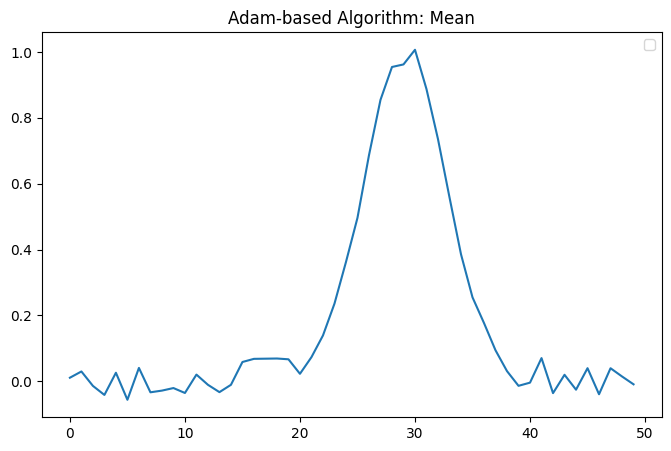

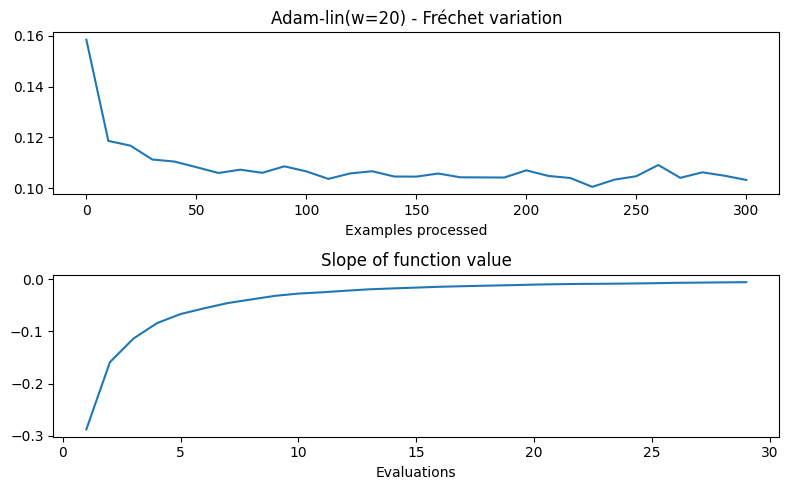

In [8]:
# generate dataset
X = generate_pulse_dataset(n_series=300, length=50)
x0 = default_init(X)

# define step size schedule. Alternatively, a fixed
# value lite eta = 0.001 would do as well
eta_lin = linear_schedule(size=1000, eta_init=0.01, eta=0.001)

# choose an optimizer
optimizer = Adam(eta=eta_lin)

# define a convergence checker for early stopping
convergence_checker = FunctionSlopeConvergenceChecker(
                        min_updates=20,
                        window_size=30,
                        slope_tol=-0.01,
                        n_zero_crossings=20,
                        patience=5)

# define dtw with Sakoe Chiba warping window w=20
def dtw_w(x,y): return dtw(x,y,w=20)

algo = SubgradientMeanAlgorithm(optimizer=optimizer, warping_distance=dtw_w,
                                algo_name="Adam-lin(w=20)")

# We use 10 epochs * 300 samples => at most 3000 samples are processed.
# Note in the plot below that the convergence checker stops early, because 
# the slope of the objective function stabilizes near zero.
result = algo.compute_mean(X=X,
                x_init=x0,
                batch_size=1,
                n_epochs=10,
                convergence_checker=convergence_checker,
                computeF=True, 
                Feval_interval=10,
                return_best_solution=True)

result.print_stats()

# Plot mean
plt.figure(figsize=(8, 5))
plt.plot(result.mean)
plt.legend()
plt.title("Adam-based Algorithm: Mean")
plt.show()

# plot convergence stats
result.plot(figsize=(8, 5))

# 6. Visualizations

## Alignment plots

Alignnment plots plot zwo time series and an alignment (warping path). By default, a 
DTW path is used, but the function allows arbitrary warping paths.

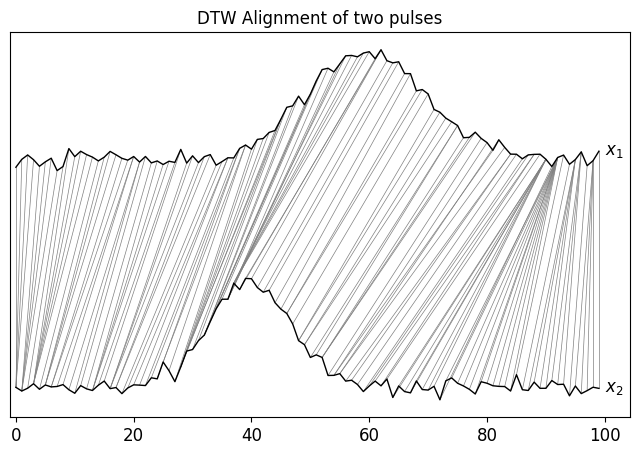

In [9]:
# Generate two time series
x1 = generate_pulse(length=100, shift=10, width=2)
x2 = generate_pulse(length=100, shift=-10)

# calculate an optimal warping path by DTW
_, path = dtw(x1, x2)

alignment_plot(x1, x2, path, title="DTW Alignment of two pulses",figsize=(8, 5))


### An `alignment_plot` can be customized with many options

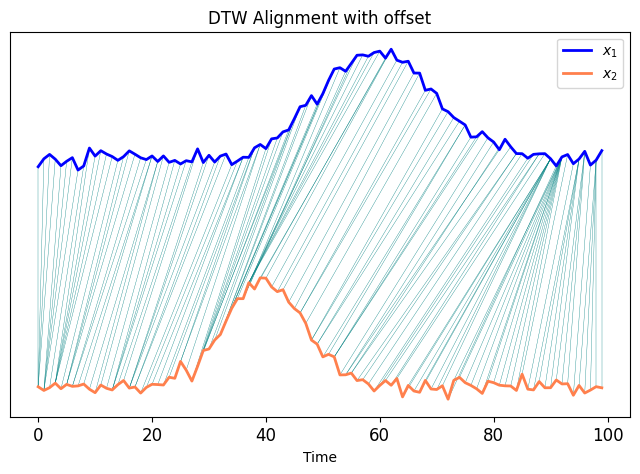

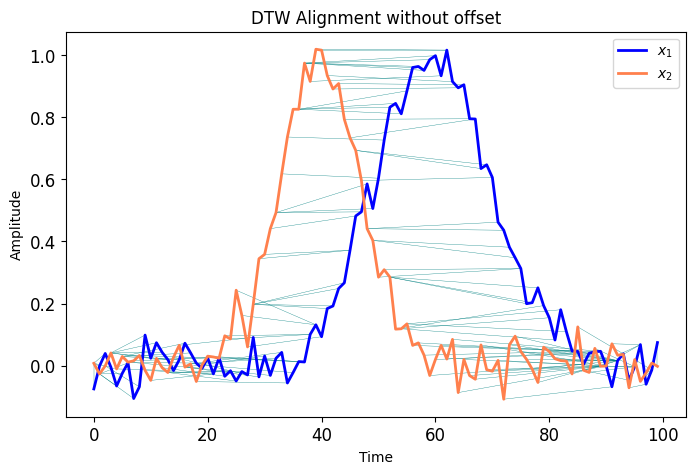

In [10]:
for offset in [True, False]:
    title ="DTW Alignment " + ("with offset" if offset else "without offset")
    alignment_plot(x1, x2, path, 
                    offset=offset,
                    return_fig=False,
                    title=title,
                    xlabel="Time",
                    ylabel="Amplitude",
                    legend_style=LegendStyle.STD, 
                    latex=True, 
                    x1_color='blue', 
                    x2_color=[1,0.5,0.3], # rgb color
                    p_color='teal',
                    x1_line_width=2,
                    x2_line_width=2,
                    p_line_width=0.25,
                    figsize=(8, 5),
                    font_size=12)

## Mean Alignment Plots

Mean alignment plots plot the alignments of a dataset X with a mean mu

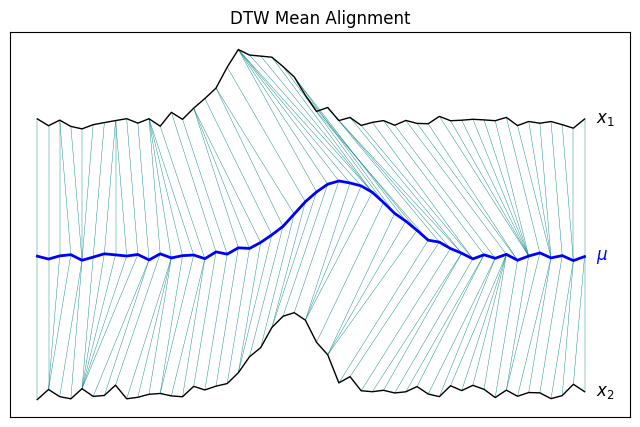

In [11]:

# We use the dataset X generated in Section 3. DBA

mean_alignment_plot(X[:2],result_dba.mean, p_line_width=0.3, p_colors='teal', x_colors='black' ,
    legend_style=LegendStyle.RIGHT_AT_TIME_SERIES, title="DTW Mean Alignment", font_size=12,
    figsize=(8, 5))

### A `mean_alignment_plot` can also be created for more than two time series

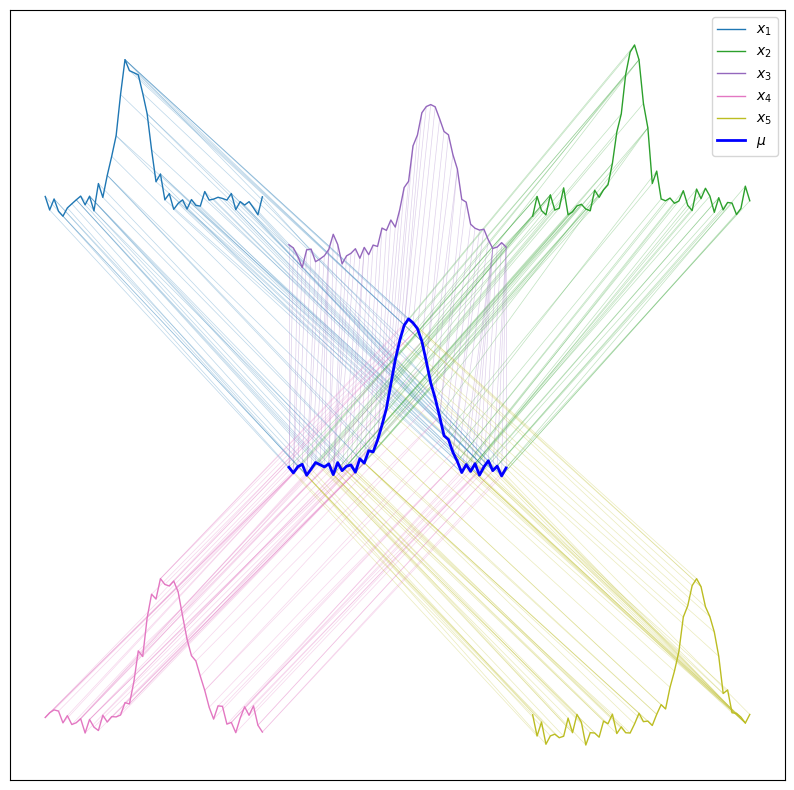

In [12]:
mean_alignment_plot(X[:5],result_dba.mean, p_alpha=0.3, figsize=(10,10))

## Summary

TSMEAN gives you the flexibility to choose between stable, classic methods like **DBA** and fast, modern stochastic methods like **SSG**. With Numba acceleration, it's ready for real-world time series workloads!